<a href="https://colab.research.google.com/github/harshgupta9723/Digit-recognition/blob/master/Digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DIGIT RECOGNITION

In [25]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data analysis and visualization on MNIST data

In [2]:
# Importing mnist data
# Data is available in splited format of train and set

project_data = pd.read_csv('/content/drive/My Drive/Project ideas/digit_recognition/data/digit-recognizer/train.csv')

# print row of project_data
print(project_data.head(5))

# save the labels into a variable label
# lable conatins the digit which is represented by pixels

label = project_data['label']

# Drop the label feature and store the pixel data into variable data.
# each row in data contains 784 pixels i.e each image is consists of 784 pixels

data = project_data.drop("label",axis=1)

   label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0      1       0       0       0  ...         0         0         0         0
1      0       0       0       0  ...         0         0         0         0
2      1       0       0       0  ...         0         0         0         0
3      4       0       0       0  ...         0         0         0         0
4      0       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]


In [3]:
# Explaination about image

print("This represents (no. of rows, no. of columns) in the data - ",data.shape)
print("no. of lables - ",label.shape)

This represents (no. of rows, no. of columns) in the data -  (42000, 784)
no. of lables -  (42000,)


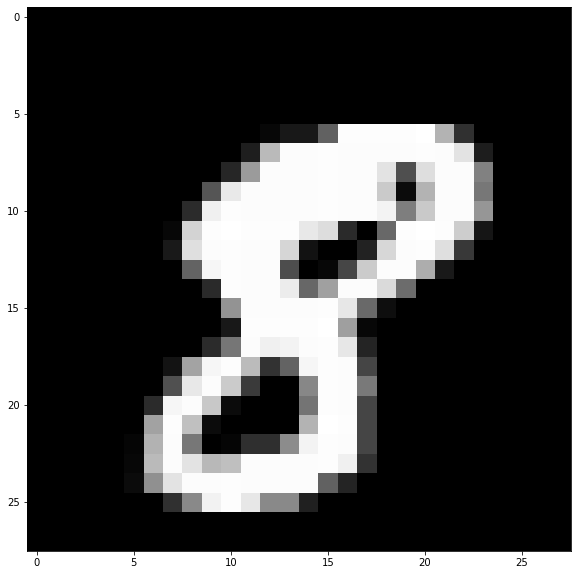

In [7]:
# display or plot a number.


# data.iloc[1] - function is used to get row of given index (mainly used when data is not provided in index)
# .to_numpy() - function is used to convert given row into numpy array, to further convert it into (28,28) pixels
# .reshape(28,28) - function is used to convert 784 pixel data point into 28 rows and 28 columns

index = 10

grid_data = data.iloc[index].to_numpy().reshape(28,28)

# figsize is used to define size of the image
plt.figure(figsize=(10,10))

# imshow plot numpy array (28,28)
plt.imshow(grid_data,cmap = "gray")

# Split data

In [14]:
X = data
y = label


xtrain, xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=0.2)
xtrain, xcv, ytrain, ycv = train_test_split(xtrain, ytrain, stratify=ytrain, test_size=0.2)

# Encoding techniques 

In [18]:
# Data-preprocessing: normalizing the data

xtrain_normalized = preprocessing.normalize(xtrain)
xtest_normalized = preprocessing.normalize(xtest)
xcv_normalized = preprocessing.normalize(xcv)

# Model taining

In [ ]:
# hyper parameter tuning of sgd classifier

# declare range of alpha(hyper parameter)
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)

    # use class_weight = 'balanced' for imbalanced dataset
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(xtrain_normalized, ytrain)

    # calibrated classifier to calculate the probablity of predicted categorys
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(xtrain_normalized, ytrain)
    sig_clf_probs = sig_clf.predict_proba(xcv_normalized)
    cv_log_error_array.append(log_loss(ycv, sig_clf_probs, labels=clf.classes_, eps=1e-15))

    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(ycv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


# get best alpha for minimum log loss
best_alpha = np.argmin(cv_log_error_array)

# train model for on best hyper parameter
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log',random_state=42)
clf.fit(xtrain_normalized, ytrain)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(xtrain_normalized, ytrain)

predict_y = sig_clf.predict_proba(xtrain_normalized)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(ytrain, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(xcv_normalized)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(ycv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(xtest_normalized)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(ytest, predict_y, labels=clf.classes_, eps=1e-15))